In [ ]:
!pip install tslearn

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
from tslearn.clustering import KShape, silhouette_score

import gc
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
import math
import warnings
from scipy import stats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [ ]:
#read data
locus_weights=pd.read_csv('data\\evt_movement_ratio_with_dates.csv')
locus_weights.starttime = pd.to_datetime(locus_weights.starttime,format='%Y-%m-%d')
locus_weights.endtime = pd.to_datetime(locus_weights.endtime,format='%Y-%m-%d')

temperature = pd.read_csv('data\\temperature_for_CAM.csv')
temperature.event_date = pd.to_datetime(temperature.event_date,format='%Y-%m-%d')
temperature.locus_group_id=temperature.locus_group_id.astype('int16')
#not sure in row below as it 'converts' 12.3 -> 12.296875
temperature.value=temperature.value.astype('float16')
temperature['event_year']=temperature['event_date'].dt.year

llg_match= pd.read_csv('data\\locus_locus_group_matching.csv')
llg_match.locus_id=llg_match.locus_id.astype('int32')
llg_match.locus_group_id=llg_match.locus_group_id.astype('int16')

df_dates=pd.read_csv('data\\FW_cycle_dates.csv')
for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
    df_dates[d] = pd.to_datetime(df_dates[d],format='%Y-%m-%d')

sfm = pd.read_csv('data\\seawater_freshwater_matching.csv')
sfm_=sfm[sfm.origin_site_type=='Freshwater'][['target_seawater_locus_id','transport_date','ponding_date','pretransfer_fw_locus_population_id','fish_count_shipped_out','avg_weight_g_stocked']]
sfm_.pretransfer_fw_locus_population_id=sfm_.pretransfer_fw_locus_population_id.astype('int64')

df_target=pd.read_csv('data\\tmp_target.csv')
df_target['transfer_date'] = pd.to_datetime(df_target['transfer_date'],format='%Y-%m-%d')
df_target['transport_year']=df_target['transfer_date'].dt.year

lw_alldates_final = pd.read_csv('lw_alldates_final_locus.csv')

#dft and dft_filled are output datasets from this notebook - please refer to the algorithms below
#read temperature processed data
# dft=pd.read_csv('data\\lw_alldates_final_grouped.csv')
# dft.event_date = pd.to_datetime(dft.event_date,format='%Y-%m-%d')

# dft_filled=pd.read_csv('data\\FW_temperature_filled.csv')
# dft_filled.event_date = pd.to_datetime(dft_filled.event_date,format='%Y-%m-%d')

# dft_filled2=pd.read_csv('data\\FW_temperature_filled2_Isolation_Forest.csv')
# dft_filled2.event_date = pd.to_datetime(dft_filled2.event_date,format='%Y-%m-%d')

FileNotFoundError: ignored

In [ ]:
lw_dates=locus_weights.groupby('final_locus_population_id').agg({'starttime':'min','endtime':'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime,format='%Y-%m-%d')
lw_dates.endtime = pd.to_datetime(lw_dates.endtime,format='%Y-%m-%d')
#to be checked
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days+1
lw_dates['starttime_year']=lw_dates['starttime'].dt.year
#we limit FW cycles to those started in 2017 because there are issues with temperature readings for 2015-2016
lw_dates_2017=lw_dates[lw_dates.starttime_year>=2017]

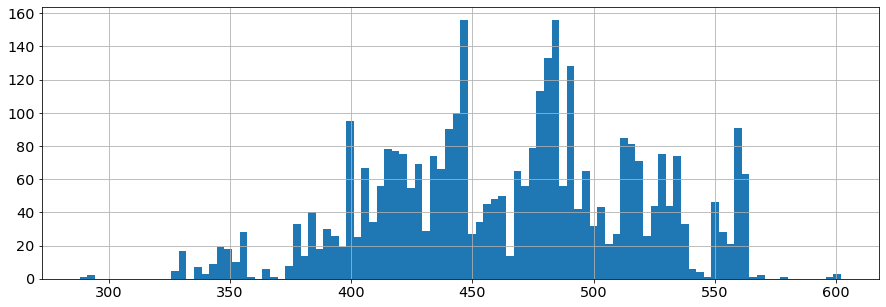

In [ ]:
# lw_dates['FW_cycle_length'].hist(bins=100)
# # plt.savefig('FW_cycle_length.jpg')

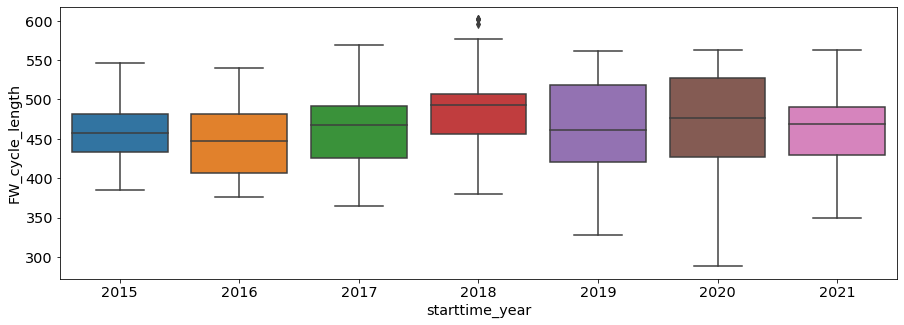

In [ ]:
# fig,axs=plt.subplots()
# arr_for_chart = lw_dates
# sns.boxplot(data=arr_for_chart,x='starttime_year',y='FW_cycle_length')
# #hatching year might be inaccurate alias for starttime_year
# # plt.savefig('boxplot_FW_cycle_length_hatching_year.jpg')

# # count of final_locus_population
# # tmp_xlabels=[]
# # for i in range(len(axs.get_xticklabels())):
# #     ttext=axs.get_xticklabels()[i].get_text()
# #     tmp_xlabels.append(ttext+'('+str(arr_for_chart.starttime_year.value_counts()[int(ttext)])+')')
# # axs.set_xticklabels(tmp_xlabels)

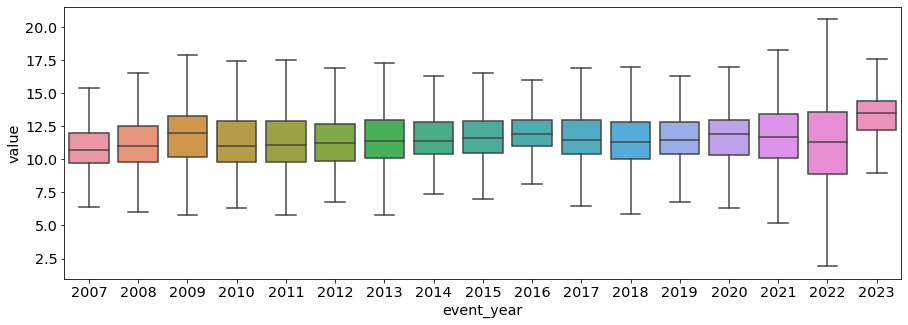

In [ ]:
# fig,axs=plt.subplots()
# arr_for_chart = temperature
# sns.boxplot(data=arr_for_chart,x='event_year',y='value',showfliers=False)
# #hatching year might be inaccurate alias for starttime_year
# plt.savefig('boxplot_temperature_vs_event_year.jpg')

# # count of final_locus_population
# # tmp_xlabels=[]
# # for i in range(len(axs.get_xticklabels())):
# #     ttext=axs.get_xticklabels()[i].get_text()
# #     tmp_xlabels.append(ttext+'('+str(arr_for_chart.event_year.value_counts()[int(ttext)])+')')
# # axs.set_xticklabels(tmp_xlabels)

In [ ]:
#time consuming
lw_alldates_list = []
for ind, row in locus_weights.iterrows():
    if ind%10000==0:
        print(ind)
    for d in pd.date_range(row.starttime,row.endtime-datetime.timedelta(days=1)):
#         print(d)
        lw_alldates_list.append([row.final_locus_population_id,d,row.historic_locus_id,row.count_ratio])
lw_alldates = pd.DataFrame(lw_alldates_list, columns = ['final_locus_population_id','event_date','historic_locus_id','weight0'])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [ ]:
#recalculating weights on date-locus level
lw_alldates_weights_grouped=lw_alldates.groupby(['final_locus_population_id','event_date'])[['weight0']].sum().reset_index()
lw_alldates_weights_grouped_merged=lw_alldates.merge(lw_alldates_weights_grouped, on =['final_locus_population_id','event_date'],how='left')
lw_alldates_weights_grouped_merged['weight']=lw_alldates_weights_grouped_merged['weight0_x']/lw_alldates_weights_grouped_merged['weight0_y']
lw_alldates_final=lw_alldates_weights_grouped_merged[['final_locus_population_id', 'event_date', 'historic_locus_id','weight']].sort_values(by=['final_locus_population_id','event_date','historic_locus_id'])
lw_alldates_final.historic_locus_id=lw_alldates_final.historic_locus_id.astype('int32')
#not sure in row below
lw_alldates_final.weight=lw_alldates_final.weight.astype('float16')
#for each final_locus_population_id for each date sum of weights equals 1 (or 100%)
#Thus, lw_alldates_final.groupby(['final_locus_population_id', 'event_date']).weight.sum() is always 1
#to use this dataframe e.g., for temperature you'd multiply value of temperature on each date for each historic_locus_id on weight and take weighted sum as resulting value for a specific date for a specific final_locus_population_id
lw_alldates_final

In [ ]:
# Start from here

In [ ]:
lw_alldates_final_=lw_alldates_final.merge(llg_match,left_on='historic_locus_id', right_on='locus_id', how='left')
#alternatively rename column before merging. Thus not having to drop column thereafter
lw_alldates_final_.drop(columns='locus_id',inplace=True)
lw_alldates_final=[]

In [ ]:
# gc.collect()
lw_alldates_final__=lw_alldates_final_.merge(temperature[['locus_group_id', 'event_date', 'value']],how='left')
lw_alldates_final__['event_year']=lw_alldates_final__['event_date'].dt.year
# lw_alldates_final__.groupby('event_year').value.count()
#30% of dates were not matched
#temperature readings for 2015 and 2016 are absent in evt_logbook
#3% of cages were not matched

#removed absent records for temperature and values above 20 degrees
#add coverage here? to understand how much of temperature data is missed
#alternatively can replace NaN with some average value
# lw_alldates_final__=lw_alldates_final__[lw_alldates_final__.value<20]
lw_alldates_final__.rename(columns={'value':'temperature'},inplace=True)
lw_alldates_final__.temperature=lw_alldates_final__.temperature.astype('float32').round(1)
lw_alldates_final__['weight_temperature']=lw_alldates_final__['weight']*lw_alldates_final__['temperature']

In [ ]:
lw_alldates_final_grouped=lw_alldates_final__.groupby(['final_locus_population_id','event_date'])[['weight_temperature']].sum().reset_index()
#len(lw_alldates_final_grouped.final_locus_population_id.unique())/len(locus_weights.final_locus_population_id.unique())
#after temperature processing 6% of final_locus_population_id have been lost
lw_alldates_final_grouped.rename(columns={'weight_temperature':'temperature'},inplace=True)
# lw_alldates_final_grouped['temperature']=lw_alldates_final_grouped['temperature'].round(1).astype('str')
# lw_alldates_final_grouped.to_csv('data//lw_alldates_final_grouped.csv',index=False)

In [ ]:
# lw_dates.loc[36778910]
# locus_weights[locus_weights.final_locus_population_id==36778910].historic_locus_id.unique()
# lw_alldates[lw_alldates.final_locus_population_id==36778910].to_csv('tmp_check_36778910.csv',index=False)

array([3046161, 3046183, 3046261, 3046268, 3046378, 3046413, 3046554,
       3046598, 3046695, 3046727, 3046746, 3046760, 3046841, 3046930,
       3046938, 3047055, 3047068, 3047069, 3047087, 3047097, 3047106,
       3047161, 3047249, 3047261, 3047285, 3047313, 3047397, 3047498,
       3047531, 3047544, 3047577, 3047615, 3047650, 3047660, 3047666,
       3047670, 3047682, 3047730, 3047754, 3047806, 3047857, 3047872,
       3047896, 3047904, 3047927, 3047935, 3048195, 3048269, 3048283,
       3048308, 3048380, 3048463, 3048534, 3048539, 3048632, 3048634,
       3048642, 3048685, 3048722, 3048725, 3048751, 3048830, 3048954,
       3048999, 3049073, 3049082, 3049101, 3049178, 3049200, 3049262,
       3049264, 3049308, 3049488, 3049579, 3049608, 3049656, 3049717,
       3049760, 3049786, 3049789, 3049878, 3050035, 3050040, 3050045,
       3050051, 3050098, 3050116, 3050185, 3050197, 3050198, 3050229,
       3050232, 3050426, 3050435, 3050466, 3050481, 3050482, 3050554,
       3050600, 3050

In [ ]:
#dft=pd.read_csv('data\\lw_alldates_final_grouped.csv')

#this to interpolate

df_dates_2017=df_dates.merge(lw_dates_2017.reset_index()[['final_locus_population_id']],left_on='pretransfer_fw_locus_population_id',right_on='final_locus_population_id',how='inner')
df_dates_2017.drop(columns=['final_locus_population_id'],inplace=True)

tmp_list=[]
for ind,row in df_dates_2017.iterrows():
    lp = row.pretransfer_fw_locus_population_id
    start = row.first_movement_date
    end = row.shipout_date
    for d in pd.date_range(start,end):
        tmp_list.append([lp,d])
tmp_df=pd.DataFrame(tmp_list,columns=['final_locus_population_id','event_date'])
dft_=tmp_df.merge(dft,how='left')

In [ ]:
#interpolation method #1 without handling outliers
output_df_temp = pd.DataFrame()
for ind,curr_df in dft_.groupby('final_locus_population_id'):
    tmp_df=curr_df.copy()
    tmp_df.temperature=curr_df.temperature.interpolate()
    output_df_temp=pd.concat([output_df_temp,tmp_df])
dft_filled = output_df_temp.copy()

In [ ]:
#interpolation method #2 with handling outliers using isolation forest algorithm - not ideal and not used
output_df_temp = pd.DataFrame()
for ind,curr_df in dft_.groupby('final_locus_population_id'):
# for ind,curr_df in dft_[dft_.final_locus_population_id==194650516].groupby('final_locus_population_id'):
    tmp_df=curr_df.copy().reset_index(drop=True)
    tmp_df_=tmp_df.dropna()

    #IFoutput - contains output of isolation forest algorithm (-1,1) to detect outliers
    X = np.array(tmp_df_.temperature).reshape(-1, 1)
    IFoutput = IsolationForest(random_state=0).fit_predict(X)
    IFoutput[IFoutput==-1]=0
    tmp_df_2=tmp_df_[IFoutput.astype('bool')]
    tmp_df_3=tmp_df[['final_locus_population_id','event_date']].merge(tmp_df_2,how='left')
    tmp_df.temperature=tmp_df_3.temperature.interpolate()
    output_df_temp=pd.concat([output_df_temp,tmp_df])
dft_filled2 = output_df_temp.copy()

In [ ]:
lp_random=np.random.permutation(dft.final_locus_population_id.unique())

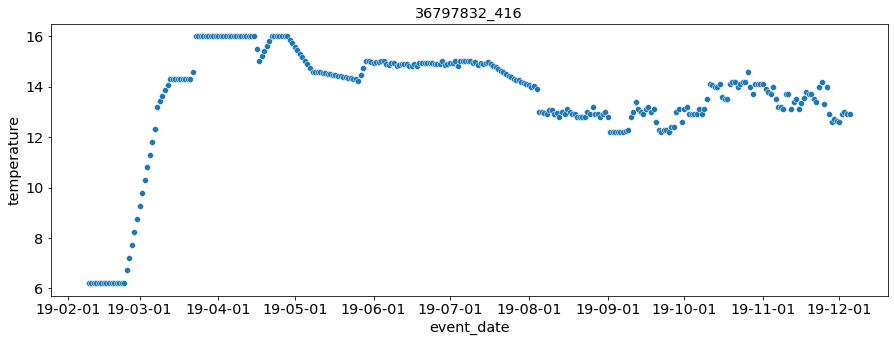

In [ ]:
# # for lp in dft.final_locus_population_id.unique():
# for lp in [36797832]:
# # for lp in lp_random[:10]:
#     filtered_df = dft_filled2[dft_filled2.final_locus_population_id==lp]
#     if not(filtered_df.empty):
#         fig, axs = plt.subplots(1, 1)
#         sns.scatterplot(data=filtered_df, x='event_date',y='temperature')
#         plt.title(str(lp)+'_'+str(len(filtered_df)))
#         axs.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

In [ ]:
#plot temperature time series charts
j=0
for lp in dft_filled.final_locus_population_id.unique():
# for lp in [38195249]:
# for lp in lp_random[:10]:
    filtered_df = dft_filled[dft_filled.final_locus_population_id==lp]
    if not(filtered_df.empty):
        j+=1
        if (j%100==0): print(j)
        fig, axs = plt.subplots(1, 1)
        sns.scatterplot(data=filtered_df, x='event_date',y='temperature')
        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days'
        plt.title(chart_title)
        min_temperature = filtered_df.temperature.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        plt.xlim(first_movement_date-datetime.timedelta(days=7),shipout_date+datetime.timedelta(days=7))
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            plt.axvline(date, linestyle='--')
            plt.text(date + datetime.timedelta(days=1), min_temperature, name+'='+date.strftime("%Y-%m-%d"), rotation=90)

#         plt.savefig('Visualisation\\Temperature\\'+chart_title+'.jpg')
        plt.close()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [ ]:
temp_factors_list = []
j=0
for lp in dft_filled.final_locus_population_id.unique():
    j+=1
    if j%100==0: print(j)
    filtered_df = dft_filled[dft_filled.final_locus_population_id == lp]

    hatching_date = filtered_df.dropna().event_date.min()
    first_feeding_date = df_dates[df_dates.pretransfer_fw_locus_population_id == lp].first_feeding_date.iloc[0]
    shipout_date = filtered_df.event_date.max()

    filtered_df1 = filtered_df[filtered_df.event_date.between(hatching_date, first_feeding_date, inclusive='left')]
    filtered_df2 = filtered_df[filtered_df.event_date.between(first_feeding_date, shipout_date, inclusive='both')]

    temp_mean_hatching_feeding = filtered_df1.temperature.mean()
    temp_sum_hatching_feeding = float('nan') if math.isnan(temp_mean_hatching_feeding) else filtered_df1.temperature.sum()

    temp_mean_feeding_shipout = filtered_df2.temperature.mean()
    temp_sum_feeding_shipout = float('nan') if math.isnan(temp_mean_feeding_shipout) else filtered_df2.temperature.sum()

    temp_factors_list.append([lp, temp_mean_hatching_feeding, temp_sum_hatching_feeding,
                              temp_mean_feeding_shipout, temp_sum_feeding_shipout])
temp_factors = pd.DataFrame(temp_factors_list,columns=['final_locus_population_id','temp_mean_hatching_feeding','temp_sum_hatching_feeding'
                                                      ,'temp_mean_feeding_shipout','temp_sum_feeding_shipout'])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


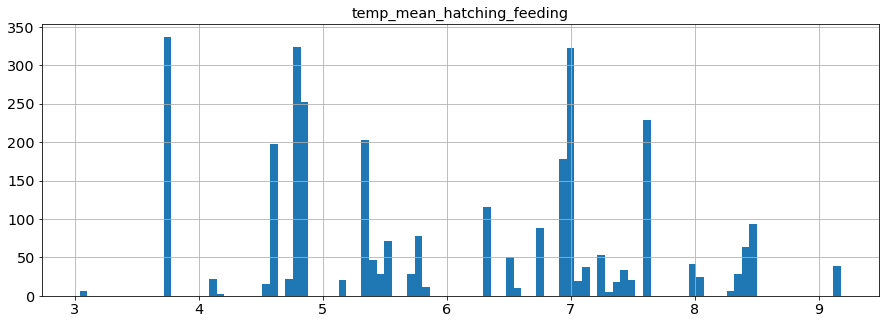

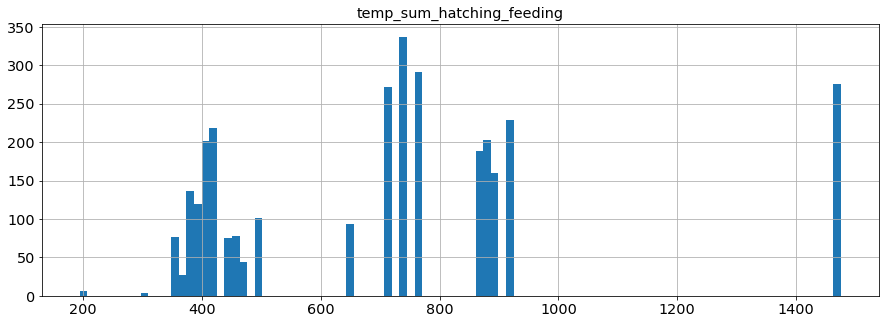

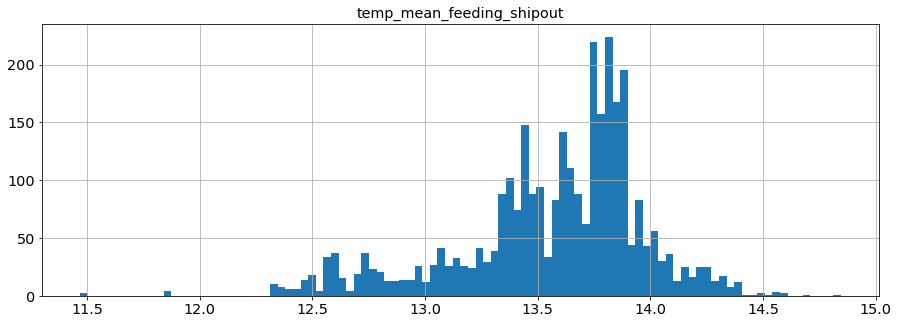

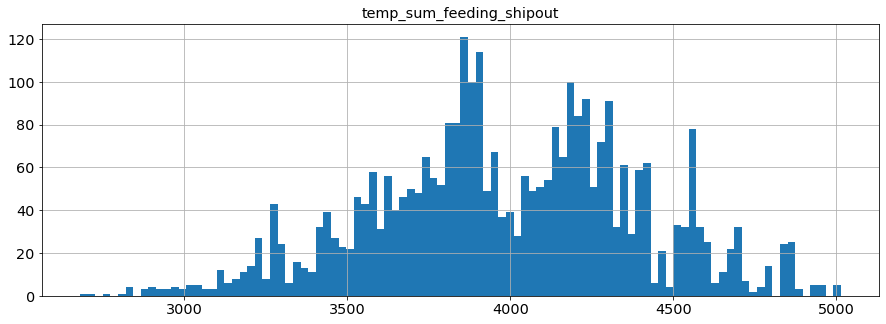

In [ ]:
# for c in temp_factors.columns[1:]:
#     plt.figure()
#     temp_factors[c].hist(bins=100)
#     plt.title(c)
# #     plt.savefig('Visualisation\\'+c+'.jpg')

In [ ]:
# dft_filled.to_csv('data\\FW_temperature_filled.csv',index=False)
# dft_filled2.to_csv('data\\FW_temperature_filled2_Isolation_Forest.csv',index=False)

<AxesSubplot:>

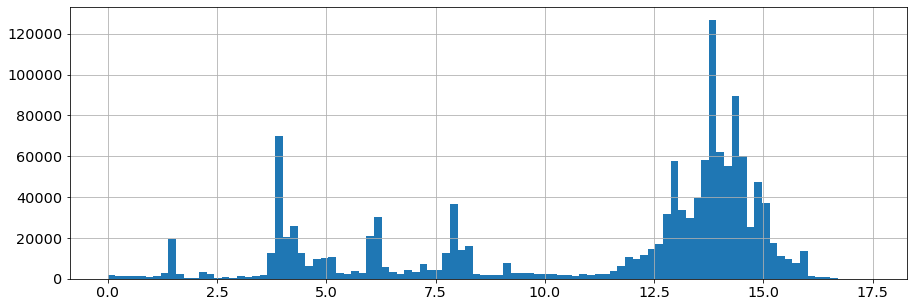

In [ ]:
dft_filled.temperature.hist(bins=100)
# plt.savefig('temperature_values_distrubtion_since_2017.jpg')

In [ ]:
df_factors = sfm_.merge(temp_factors, left_on='pretransfer_fw_locus_population_id', right_on='final_locus_population_id',how='left')#.isna().sum()
df_factors['transport_date'] = pd.to_datetime(df_factors['transport_date'],format='%Y-%m-%d')
df_factors['transport_year']=df_factors['transport_date'].dt.year

In [ ]:
#here we make an assumption that each seawater cage could be stocked only once per year
#the only problem here where stocking is around January-1, corresponds to <0.5% of cases
df_factors_ = df_factors[['target_seawater_locus_id','transport_year']].drop_duplicates().reset_index(drop=True)

for factor in ['temp_mean_hatching_feeding', 'temp_sum_hatching_feeding','temp_mean_feeding_shipout', 'temp_sum_feeding_shipout']:
    tmp=df_factors.groupby(['target_seawater_locus_id','transport_year']).apply(weighted_avg,'fish_count_shipped_out',factor).reset_index()
    tmp.rename(columns={0:factor},inplace=True)
    df_factors_=df_factors_.merge(tmp)

In [ ]:
df_final = df_factors_.merge(df_target, left_on=['target_seawater_locus_id','transport_year'], right_on=['locus_id','transport_year'],how='left')#.isna().sum()
df_final['temp_sum_hatching_shipout']=df_final['temp_sum_hatching_feeding']+df_final['temp_sum_feeding_shipout']

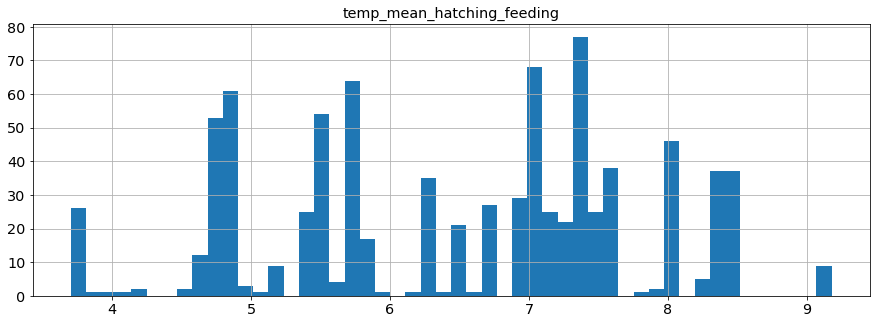

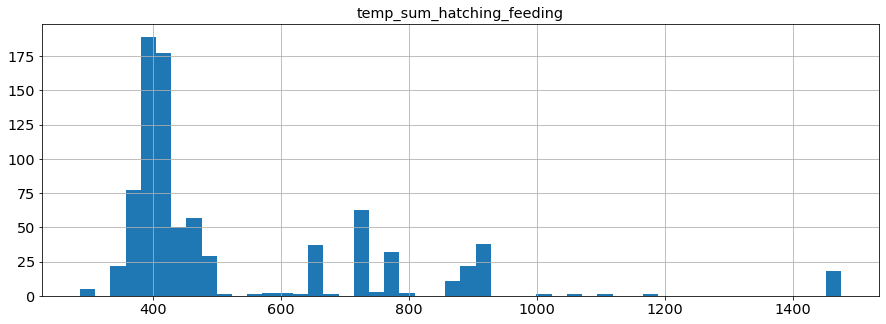

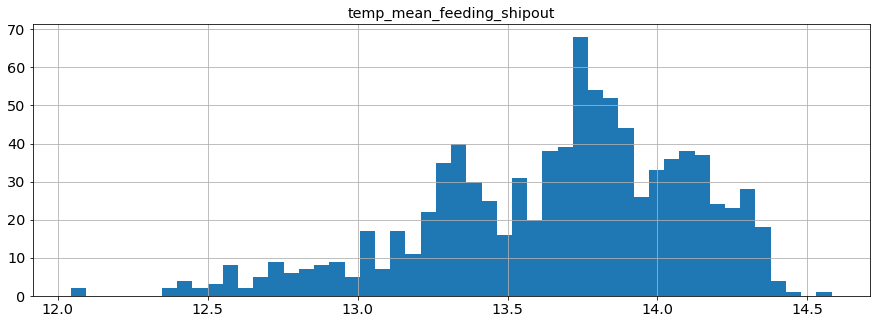

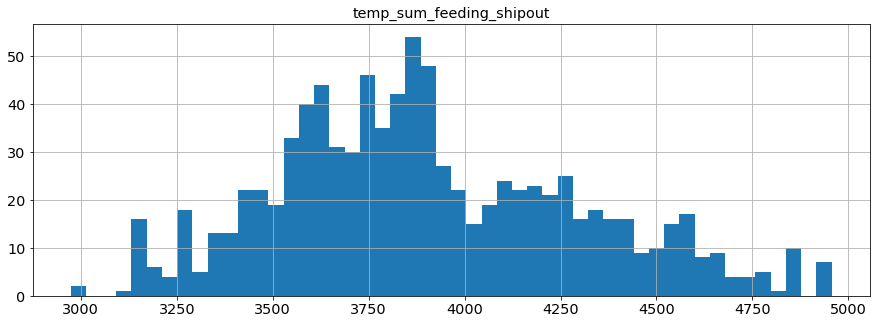

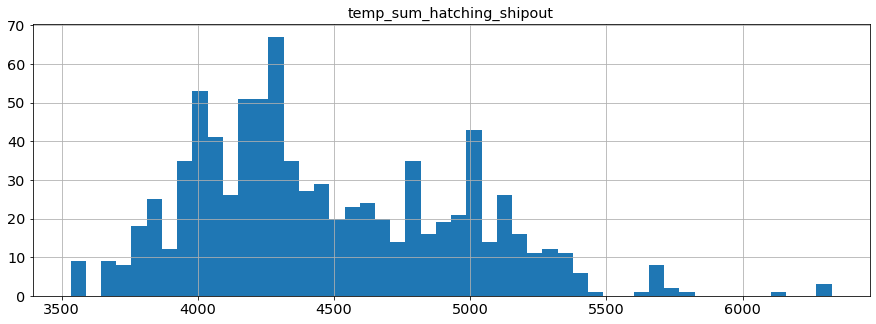

In [ ]:
for f in ['temp_mean_hatching_feeding', 'temp_sum_hatching_feeding','temp_mean_feeding_shipout', 'temp_sum_feeding_shipout','temp_sum_hatching_shipout']:
    plt.figure()
    df_final[df_final[f]>0][f].hist(bins=50)
    plt.title(f)
#     plt.savefig('Visualisation\\Histograms\\'+f+'_on_seawater_locus_level.jpg')

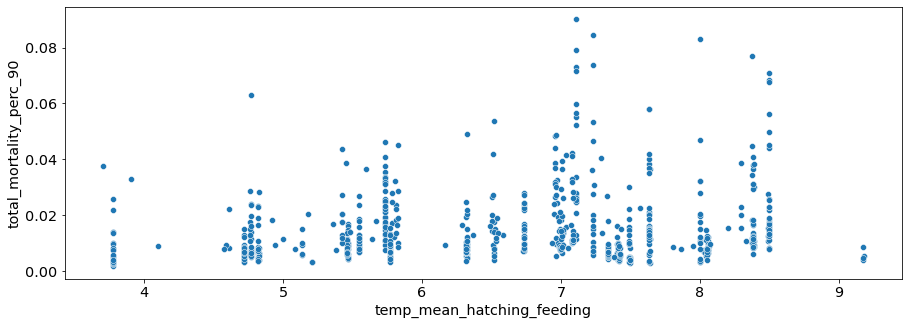

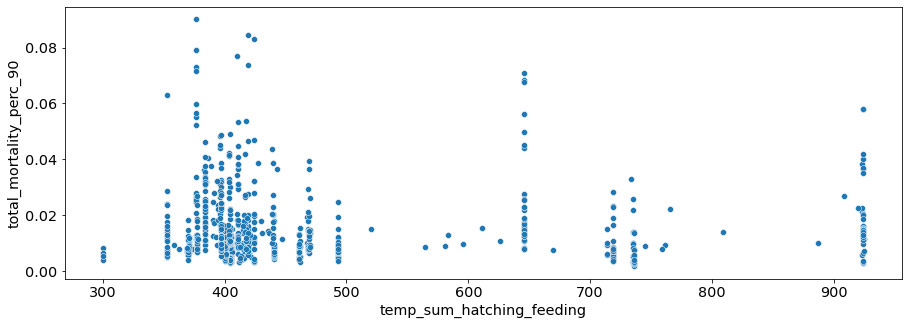

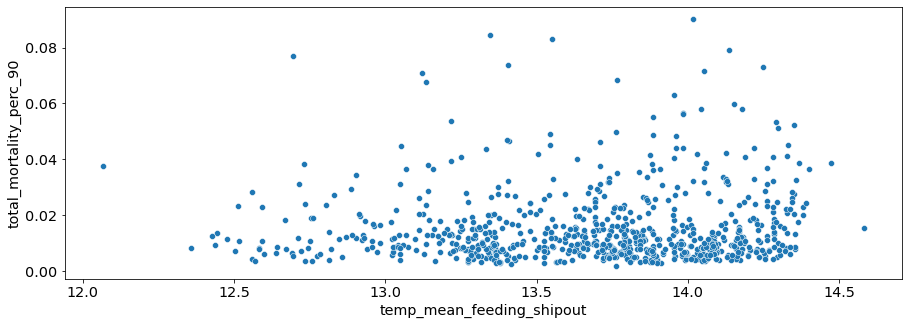

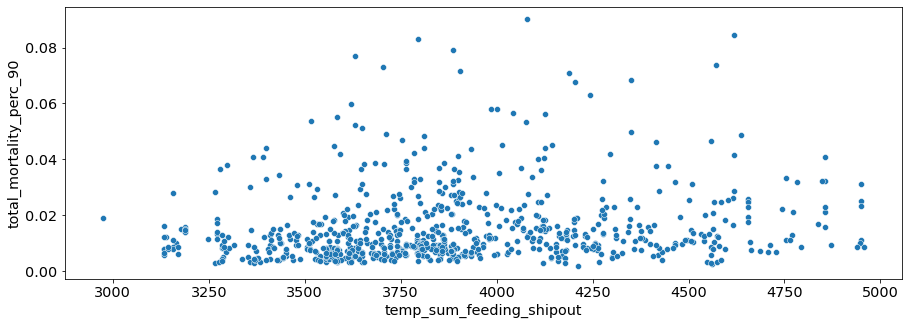

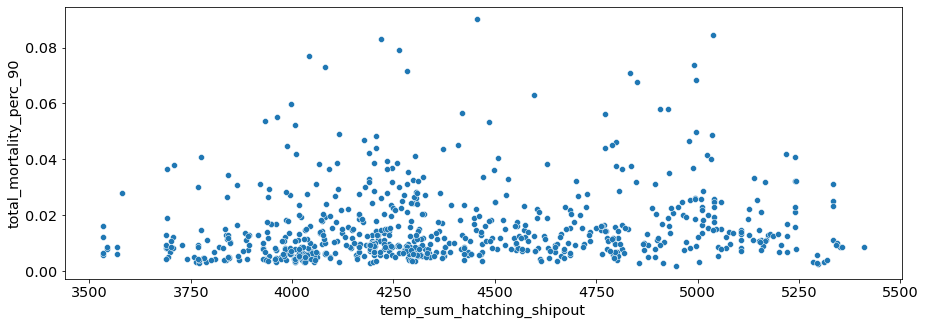

In [ ]:
for f in ['temp_mean_hatching_feeding', 'temp_sum_hatching_feeding','temp_mean_feeding_shipout', 'temp_sum_feeding_shipout','temp_sum_hatching_shipout']:
    arr_for_chart=df_final[df_final[f]>0]
    plt.figure()
    sns.scatterplot(data=arr_for_chart,y='total_mortality_perc_90',x=f)
#     plt.savefig('Visualisation\\Scatters\\'+f+'_on_seawater_locus_level.jpg')

In [ ]:
df_final[df_final[f]>0].corr()

,target_seawater_locus_id,transport_year,temp_mean_hatching_feeding,temp_sum_hatching_feeding,temp_mean_feeding_shipout,temp_sum_feeding_shipout,locus_id,total_mortality_perc_90,temp_sum_hatching_shipout
target_seawater_locus_id,1.000000,0.375005,-0.208115,0.421826,-0.070694,0.054907,1.000000,-0.005786,0.238355
transport_year,0.375005,1.000000,-0.224811,0.697599,-0.306627,0.201989,0.490724,0.072053,0.483390
temp_mean_hatching_feeding,-0.208115,-0.224811,1.000000,-0.115896,0.194843,-0.058177,-0.228736,0.176482,-0.100061
temp_sum_hatching_feeding,0.421826,0.697599,-0.115896,1.000000,0.006590,0.194943,0.606564,-0.008177,0.617029
temp_mean_feeding_shipout,-0.070694,-0.306627,0.194843,0.006590,1.000000,0.159753,-0.054469,0.079196,0.131211
temp_sum_feeding_shipout,0.054907,0.201989,-0.058177,0.194943,0.159753,1.000000,0.092548,0.164656,0.892128
locus_id,1.000000,0.490724,-0.228736,0.606564,-0.054469,0.092548,1.000000,-0.005786,0.296255
total_mortality_perc_90,-0.005786,0.072053,0.176482,-0.008177,0.079196,0.164656,-0.005786,1.000000,0.145502
temp_sum_hatching_shipout,0.238355,0.483390,-0.100061,0.617029,0.131211,0.892128,0.296255,0.145502,1.000000


In [ ]:
df_final[df_final['temp_sum_hatching_feeding'].between(300,500)].corr()

,target_seawater_locus_id,transport_year,temp_mean_hatching_feeding,temp_sum_hatching_feeding,temp_mean_feeding_shipout,temp_sum_feeding_shipout,locus_id,total_mortality_perc_90,temp_sum_hatching_shipout
target_seawater_locus_id,1.000000,0.124302,-0.282167,-0.298910,-0.213198,-0.009447,1.000000,-0.097023,-0.034339
transport_year,0.124302,1.000000,0.108059,0.300955,-0.512379,0.164513,0.136323,0.134377,0.188430
temp_mean_hatching_feeding,-0.282167,0.108059,1.000000,0.089324,0.072072,-0.178131,-0.287979,0.071380,-0.169356
temp_sum_hatching_feeding,-0.298910,0.300955,0.089324,1.000000,-0.015688,0.046725,-0.302452,-0.171121,0.129891
temp_mean_feeding_shipout,-0.213198,-0.512379,0.072072,-0.015688,1.000000,0.109060,-0.217544,0.048938,0.106944
temp_sum_feeding_shipout,-0.009447,0.164513,-0.178131,0.046725,0.109060,1.000000,-0.006717,0.175820,0.996515
locus_id,1.000000,0.136323,-0.287979,-0.302452,-0.217544,-0.006717,1.000000,-0.097023,-0.032331
total_mortality_perc_90,-0.097023,0.134377,0.071380,-0.171121,0.048938,0.175820,-0.097023,1.000000,0.160395
temp_sum_hatching_shipout,-0.034339,0.188430,-0.169356,0.129891,0.106944,0.996515,-0.032331,0.160395,1.000000


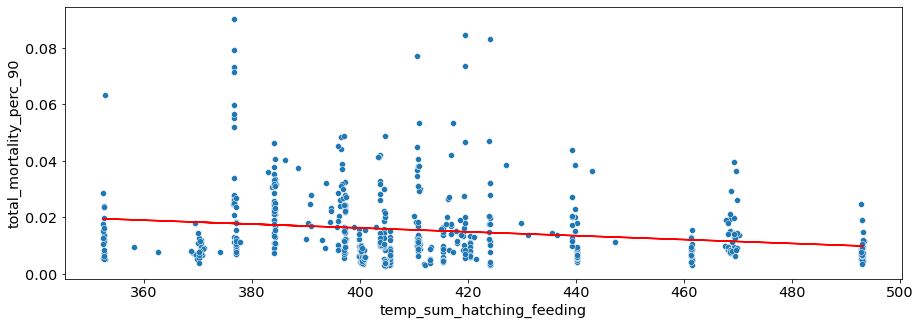

In [ ]:
factor = 'temp_sum_hatching_feeding'
# Create a filtered DataFrame
df_filtered = df_final[df_final['temp_sum_hatching_feeding'].between(300, 500)].dropna()

# Create the scatter plot
sns.scatterplot(data=df_filtered, x=factor, y='total_mortality_perc_90')

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered[factor], df_filtered['total_mortality_perc_90'])
x = df_filtered[factor]
y = slope * x + intercept

# Add the trend line to the plot
plt.plot(x, y, color='red')

plt.savefig('Visualisation\\Scatters\\'+factor+'_filtered.jpg')

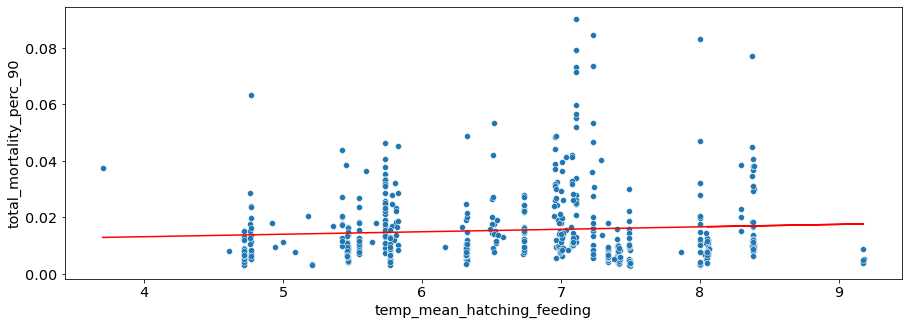

In [ ]:
factor = 'temp_mean_hatching_feeding'

# Create a filtered DataFrame
df_filtered = df_final[df_final['temp_sum_hatching_feeding'].between(300, 500)].dropna()

# Create the scatter plot
sns.scatterplot(data=df_filtered, x=factor, y='total_mortality_perc_90')

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered[factor], df_filtered['total_mortality_perc_90'])
x = df_filtered[factor]
y = slope * x + intercept

# Add the trend line to the plot
plt.plot(x, y, color='red')

plt.savefig('Visualisation\\Scatters\\'+factor+'_filtered.jpg')

In [ ]:
# df_factors.groupby('transport_year')[['temp_sum_hatching_feeding_shipout']].apply(lambda x:pd.isna(x).sum())

,temp_sum_hatching_feeding_shipout
transport_year,
2017,351
2018,86
2019,115
2020,85
2021,44
2022,534
2023,116


In [ ]:
# dft_count=pd.DataFrame(output_list,columns=['final_locus_population_id','count_temp_readings'])
# dft_count=dft_count.merge(lw_dates_2017[['FW_cycle_length','starttime_year']].reset_index(),how='inner')
# dft_count['ratio']=dft_count['count_temp_readings']/dft_count['FW_cycle_length']
# dft_count.ratio.describe()

count    3176.000000
mean        0.650394
std         0.125145
min         0.322835
25%         0.573964
50%         0.678571
75%         0.709544
max         0.862069
Name: ratio, dtype: float64

[Text(0, 0, '2017(229)'),
 Text(1, 0, '2018(224)'),
 Text(2, 0, '2019(531)'),
 Text(3, 0, '2020(887)'),
 Text(4, 0, '2021(1305)')]

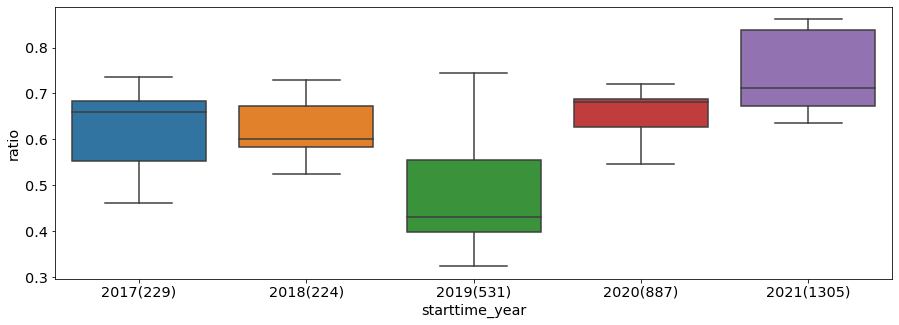

In [ ]:
# fig,axs=plt.subplots()
# arr_for_chart = dft_count
# sns.boxplot(data=arr_for_chart,x='starttime_year',y='ratio',showfliers=False)
# #hatching year might be inaccurate alias for starttime_year
# # plt.savefig('boxplot_of_temperature_data_FW_cycle_coverage.jpg')

# # count of final_locus_population
# tmp_xlabels=[]
# for i in range(len(axs.get_xticklabels())):
#     ttext=axs.get_xticklabels()[i].get_text()
#     tmp_xlabels.append(ttext+'('+str(arr_for_chart.starttime_year.value_counts()[int(ttext)])+')')
# axs.set_xticklabels(tmp_xlabels)

In [ ]:
# lw_alldates_final_grouped['temperature']=lw_alldates_final_grouped['temperature'].round(1).astype('str')
# lw_alldates_final_grouped.to_csv('data//lw_alldates_final_grouped.csv',index=False)

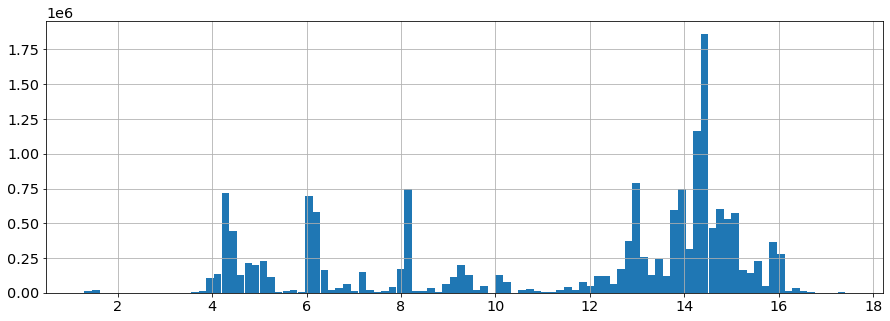

In [ ]:
# lw_alldates_final__.value.hist(bins=100)
# plt.savefig('temperature_values_distrubtion_since_2017.jpg')

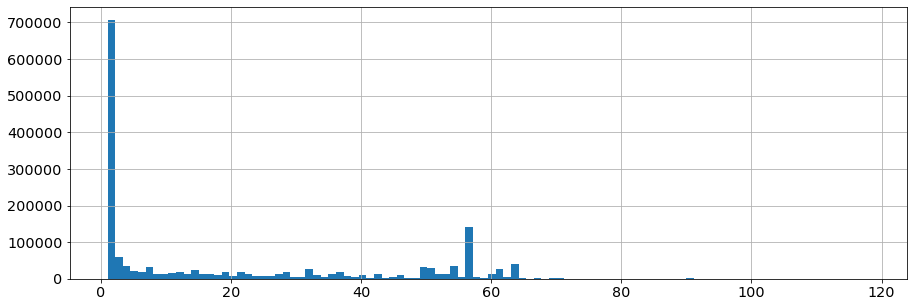

In [ ]:
# lw_alldates_final.groupby(['final_locus_population_id', 'event_date']).historic_locus_id.count().hist(bins=100)
# plt.savefig('locus count per date distribution.jpg')

In [ ]:
# lw_alldates_final[(lw_alldates_final.final_locus_population_id==36771860)&(lw_alldates_final.historic_locus_id==3047921)&(lw_alldates_final.event_date.between('2016-03-01','2016-04-01'))]

,final_locus_population_id,event_date,historic_locus_id,weight
107898,36771860,2016-03-01,3047921,0.021663
107899,36771860,2016-03-03,3047921,0.028204
107900,36771860,2016-03-04,3047921,0.028204
107901,36771860,2016-03-05,3047921,0.028204
107902,36771860,2016-03-06,3047921,0.028204
107903,36771860,2016-03-07,3047921,0.026762
107904,36771860,2016-03-08,3047921,0.026875
107905,36771860,2016-03-09,3047921,0.025772
107906,36771860,2016-03-10,3047921,0.025771
107907,36771860,2016-03-11,3047921,0.025813


In [ ]:
# locus_weights[(locus_weights.final_locus_population_id==36771860)&(locus_weights.historic_locus_id==3047921)]

,final_locus_population_id,historic_locus_population_id,historic_locus_id,starttime,endtime,count_ratio
6081,36771860,36767270,3047921,2015-12-19,2015-12-31,0.060253
6082,36771860,36767491,3047921,2015-12-31,2016-03-02,0.060253
6083,36771860,36768745,3047921,2016-03-03,2016-03-18,0.078448
6084,36771860,193337811,3047921,2016-03-18,2016-03-18,0.078448
6085,36771860,36769076,3047921,2016-03-18,2016-03-19,0.049313
6086,36771860,36769130,3047921,2016-03-21,2016-03-22,0.000233
6087,36771860,36769182,3047921,2016-03-22,2016-03-23,0.000233
6088,36771860,36769294,3047921,2016-03-23,2016-04-19,0.000233


In [ ]:
# locus_count = lw_alldates_final.groupby(['final_locus_population_id', 'event_date']).historic_locus_id.count()

In [ ]:
# check_locus = lw_alldates_final[
# (lw_alldates_final.final_locus_population_id==36771860)&(lw_alldates_final.event_date.between('2016-03-18','2016-03-18'))
# ].historic_locus_id.values

In [ ]:
# locus_weights[
#     (locus_weights.final_locus_population_id==36771860)&(locus_weights.historic_locus_id.isin(check_locus)&
#                                                         (locus_weights.starttime>'2016-03-01'))

# ].to_csv('tmp.csv',index=False
#         )